In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2g}".format
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["font.size"] = 16

# Question 1. 

What is the value of
* The expected loss of the loan (EL)?

$$\begin{aligned}
    cPD &= cDR \\
    cLoss &= cPD * cLGD \\
    EL &= \mathbb{E}[D] * \mathbb{E}[cLoss] \\
        &= 0.016
\end{aligned}$$

* The expected LGD of the loan (ELGD)?

$$\begin{aligned}
    PD &= \mathbb{P}[state] * cPD \\
    ELGD &= EL / PD \\
        &= 0.4
\end{aligned}$$

* The “time-weighted LGD” of the loan?

$$\begin{aligned}
    twLGD &= \mathbb{E}[cLGD] \\
        &= \mathbb{P}[state] * cLGD \\
        &= 0.3
\end{aligned}$$

In [2]:
dat = np.array([[0.40, 0.30, 0.20, 0.10], 
                [0.02, 0.04, 0.06, 0.08], 
                [0.10, 0.30, 0.50, 0.70]])

cLoss = dat[1,:] * dat[2,:]
EL = dat[0,:] @ cLoss
print(f"Expected Loss of the loan (EL) = {EL}")
ELGD = EL / (dat[0,:] @ dat[1,:]).sum()
print(f"The expected LGD of the loan (ELGD) = {ELGD}")
twLGD = dat[0,:] @ dat[2,:]
print(f"The “time-weighted LGD” of the loan = {twLGD}")

Expected Loss of the loan (EL) = 0.016
The expected LGD of the loan (ELGD) = 0.4
The “time-weighted LGD” of the loan = 0.3


# Question 2. 

Suppose that a loan is characterized by $PD = 5\%, ELGD = 30\%,$ and $\rho$ = 15%. Suppose that instead of the LGD function preferred by Frye and Jacobs, this loan follows the “Variant A” alternative LGD function that the authors use for hypothesis testing. Plot the function within the unit square for four values of the “a” parameter: {-2, 0, 1, 2}.

$$\begin{aligned}
    cLGD &= ELGD^a \Phi \bigg[ \Phi^{-1}[cPD] - \frac{\Phi^{-1}[PD] - \Phi^{-1}[EL / ELGD^a]}{\sqrt{1-\rho}} \bigg] / cPD \\
\end{aligned}$$

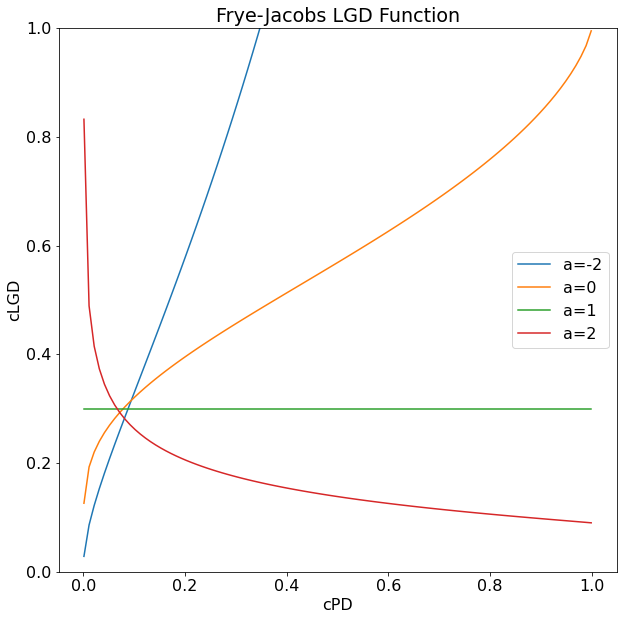

In [3]:
Phi = norm.cdf
Phinv = norm.ppf

def cLGD(a, cPD, ELGD=0.3, PD=0.05, rho=0.15):
    return ELGD**a * Phi(Phinv(cPD) - (Phinv(PD) - Phinv((ELGD*PD) / (ELGD**a)))/(1-rho)**0.5) / cPD

fig, ax = plt.subplots(figsize=(10,10))

cPD = np.linspace(1e-3, 1-1e-3, 100)
for i, a in enumerate([-2, 0, 1, 2]):
    cLGD_res = cLGD(a, cPD)
    ax.plot(cPD, cLGD_res, label=f"a={a}")

plt.title("Frye-Jacobs LGD Function")
plt.ylim([0,1])
plt.xlabel("cPD")
plt.ylabel("cLGD")
plt.legend()
plt.show()

# Question 3. 

Suppose that cPD ~ Vasicek $[ PD = 0.02, \rho = 0.10]$. Assuming that cPD and cLoss are comonotonic, plot three LGD functions for three possible distributions of cLoss:

(a) cLoss ~ Vasicek $[ EL = 0.01, \rho = 0.05]$ 

(b) cLoss ~ Vasicek $[ EL = 0.01, \rho = 0.1]$ 

(c) cLoss ~ Vasicek $[ EL = 0.01, \rho = 0.15]$

Limit the default axis to {0, 0.5} and limit the vertical axis to {0, 1.2}. Comment on the usefulness of each possible LGD function.

$$\begin{aligned}
    CDF[cPD] &= \Phi \bigg[ \frac{\sqrt{1-\rho} \Phi^{-1}[cPD] - \Phi^{-1}[PD] }{\sqrt{\rho}} \bigg] \\
    EL[q] &= \Phi \bigg[ \frac{ \Phi^{-1}[EL] + \sqrt{\rho} \Phi^{-1}[q] }{\sqrt{1-\rho}} \bigg] \\
    cLGD &= EL/cPD \\
\end{aligned}$$

Commentary:

(a) having an inverse relationship between cPD and cLGD does not make sense because losses are incurred only when defaults occur, implying a positive relationship. (a) May not be useful in application due to its aberrant behavior.

(b) positive first derivative, negative second derivative, cLGD scales relatively gently compared with cPD, with a slope nearly 1. Because this plot exhibits all the expected relationships including having an integral ELGD approximately 0.5, I believe this is the most informative and useful plot.

(c) exhibits same characteristics as (b), but slopes significantly higher in cPD values under 0.3. However, it is difficult to believe that (c) integrates to ELGD = 0.5, so this plot may not be useful.

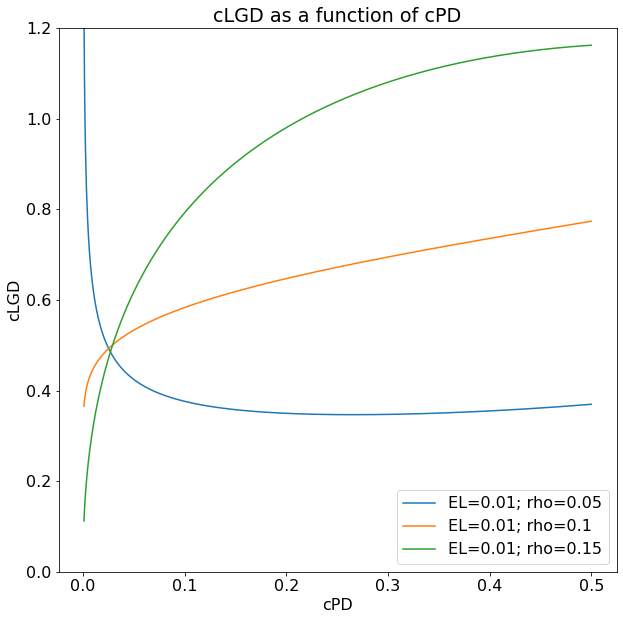

In [4]:
def vas_cdf(cPD, PD=0.02, rho=0.1):
    return Phi(((1-rho)**0.5 * Phinv(cPD) - Phinv(PD)) / (rho)**0.5)

def vas_cdf_inv(q, rho, x):
    return Phi((Phinv(x) + (rho)**0.5*Phinv(q)) / (1-rho)**0.5)

fig, ax = plt.subplots(figsize=(10,10))

cPD = np.linspace(1e-3, 0.5, 1000)
q = vas_cdf(cPD)
for letter, rho in zip(["a", "b", "c"], [0.05, 0.1, 0.15]):
    vas_res = vas_cdf_inv(q, rho, x=0.01)
    plt.plot(cPD, vas_res/cPD, label=f"EL=0.01; rho={rho}")
    
plt.title("cLGD as a function of cPD")
plt.ylim([0,1.2])
plt.ylabel("cLGD")
plt.xlabel("cPD")
plt.legend()
plt.show()

# Question 4. 

Using the assumptions of Question 3(b), what is the value of ELGD?

$$ELGD = EL/PD = 0.01/0.02 = 0.5$$